## Soild classifier train

In [137]:
import torch
import torchvision
import torchvision.transforms as transforms

In [138]:
train_path = './data/train'
test_path = './data/test'
validation_path = './data/validation'

In [139]:
import pathlib

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),  # 0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5, 0.5, 0.5],  # 0-1 to [-1,1] , formula (x-mean)/std
                         [0.5, 0.5, 0.5])
])

batch_size = 4

trainset = torchvision.datasets.ImageFolder(root=train_path, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = torchvision.datasets.ImageFolder(root=test_path, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=2)

validationset = torchvision.datasets.ImageFolder(root=validation_path, transform=transform)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size, shuffle=True, num_workers=2)


root = pathlib.Path(train_path)
classes = sorted([j.name.split('/')[-1] for j in root.iterdir()])

# CNN Network
print(classes)

['Gravel', 'Sand', 'Silt']


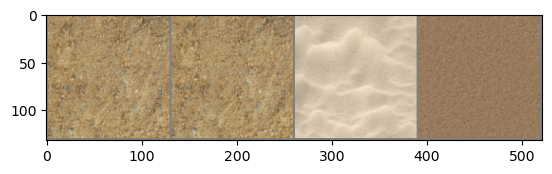

[tensor(1), tensor(1), tensor(1), tensor(1)]
Sand  Sand  Sand  Sand 


In [140]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
x = [labels[j] for j in range(batch_size)]
print(x)
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [141]:
# Get cpu, gpu or mps device for training.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [142]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self,num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.bn2 = nn.BatchNorm2d(16)
        self.bn1 = nn.BatchNorm2d(6)
        self.fc3 = nn.Linear(84, num_classes)


    def forward(self, x):
        # lets do rapid downscaling from 128 to 32
        x = self.pool(self.pool(x))
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = ConvNet(3).to(device=device)

In [143]:
print(net)


ConvNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


In [144]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-4)

In [145]:
loss_training = []
loss_validation = []

for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    size = 0
    mse = 0.0

    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        size+=1

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        mse += loss.item()**2
        if i % 5 == 4:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 5:.3f}')
            running_loss = 0.0
    loss_training.append(mse/size)
    print(f"[{epoch+1}] MSE: {mse/size:.3f}")
        # Validation
    net.eval()
    with torch.no_grad():
        correct_val = 0
        total_val = 0
        mse = 0.0
        size = 0

        for X_val, y_val in validationloader:
            X_val, y_val = X_val.to(device), y_val.to(device)

            size+=1

            val_output = net(X_val)
            loss = criterion(outputs, labels)
            mse += loss.item() ** 2

    loss_validation.append(mse/size)
    print(f"[{epoch+1}] MSE validation: {mse/size:.3f}")
print('Finished Training')


[1,     5] loss: 1.053
[1,    10] loss: 1.091
[1,    15] loss: 1.036
[1,    20] loss: 1.074
[1,    25] loss: 1.088
[1,    30] loss: 0.959
[1,    35] loss: 0.961
[1] MSE: 1.087
[1] MSE validation: 0.921
[2,     5] loss: 0.993
[2,    10] loss: 0.935
[2,    15] loss: 0.886
[2,    20] loss: 0.902
[2,    25] loss: 0.893
[2,    30] loss: 0.850
[2,    35] loss: 0.808
[2] MSE: 0.776
[2] MSE validation: 0.210
[3,     5] loss: 0.751
[3,    10] loss: 0.655
[3,    15] loss: 0.674
[3,    20] loss: 0.667
[3,    25] loss: 0.600
[3,    30] loss: 0.538
[3,    35] loss: 0.557
[3] MSE: 0.414
[3] MSE validation: 0.106
[4,     5] loss: 0.592
[4,    10] loss: 0.339
[4,    15] loss: 0.433
[4,    20] loss: 0.432
[4,    25] loss: 0.413
[4,    30] loss: 0.412
[4,    35] loss: 0.562
[4] MSE: 0.241
[4] MSE validation: 0.165
[5,     5] loss: 0.261
[5,    10] loss: 0.312
[5,    15] loss: 0.436
[5,    20] loss: 0.341
[5,    25] loss: 0.449
[5,    30] loss: 0.239
[5,    35] loss: 0.399
[5] MSE: 0.172
[5] MSE validati

In [146]:
def movingAverage(data):
    # Calculate a simple moving average with a window size of 3
    window_size = 6
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')


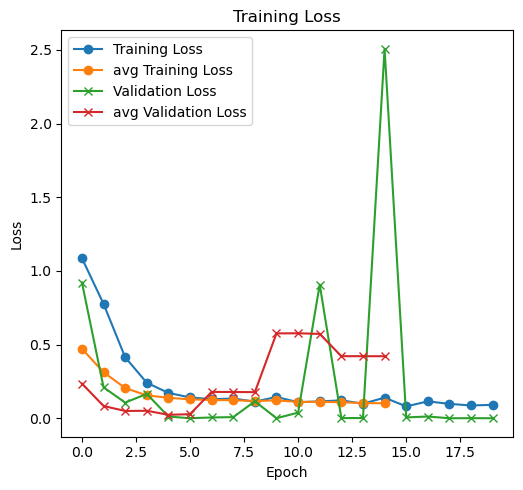

In [147]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(loss_training, label='Training Loss', marker='o')
plt.plot(movingAverage(loss_training), label='avg Training Loss', marker='o')
plt.plot(loss_validation, label='Validation Loss', marker='x')
plt.plot(movingAverage(loss_validation), label='avg Validation Loss', marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [148]:
PATH = './soil_net.pth'
torch.save(net.state_dict(), PATH)

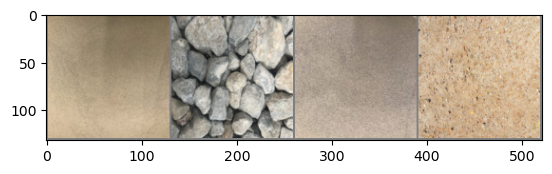

GroundTruth:  Silt  Gravel Silt  Sand 


In [149]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [150]:
net = ConvNet(3)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [151]:
outputs = net(images)

In [152]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  Silt  Gravel Silt  Sand 


In [153]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 15 test images: {100 * correct // total} %')

Accuracy of the network on the 15 test images: 72 %


In [154]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Gravel is 100.0 %
Accuracy for class: Sand  is 83.3 %
Accuracy for class: Silt  is 100.0 %
